In [ ]:
import snscrape.modules.twitter as sntwitter  # only works with python 3.11 or lower
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import emoji
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from decouple import config
import tweepy
from datetime import datetime, timedelta, timezone
import urllib
import requests

In [21]:
# Load environment variables and Authenticate via tweepy

BEARER_TOKEN = config("BEARER_TOKEN")

# Create a Tweepy Client instance for API v2
# This is the modern and recommended way to use Tweepy
try:
    client = tweepy.Client(BEARER_TOKEN)
    print("Authentication successful!")
except Exception as e:
    print(f"Error during authentication: {e}")
    # If authentication fails, we stop here.
    # Make sure your Bearer Token is correct.
    client = None

Authentication successful!


In [22]:
# --- SEARCHING FOR TWEETS ---

if client:
    # 1. Define search query.
    # You can use keywords, hashtags, or more complex rules.
    # Search for tweets about #EVs.
    # Add '-is:retweet' to exclude retweets and get more original content.
    # We also specify 'lang:en' to get English-language tweets.
    query = "#ElectricVehicles -is:retweet lang:en"

    # 2. Use the search_recent_tweets method.
    # - The 'query' parameter is what we're searching for.
    # - The 'max_results' parameter specifies how many tweets to return (10 to 100).
    #   Let's fetch 10.
    try:
        response = client.search_recent_tweets(
            query=query,
            max_results=10,
            # --- additional fields for each tweet ---
            tweet_fields=[
                "created_at",  # When the tweet was created
                "public_metrics",  # Like, retweet, reply, and quote counts
                "author_id",  # The ID of the user who posted
            ],
            # --- user information  to retrieve ---
            expansions=["author_id"],  # This tells the API to include the User object
            user_fields=[
                "username",  # The user's @handle
                "name",  # The user's display name
                "public_metrics",  # Follower/following counts for the user
            ],
        )

        # 4. Process and save the enriched data
        tweets = response.data
        users = {user["id"]: user for user in response.includes["users"]} if 'users' in response.includes else {}

        if tweets:
            print(f"Successfully fetched {len(tweets)} tweets.")
            
            # Create a list to hold our structured data
            tweet_data = []
            for tweet in tweets:
                author = users.get(tweet.author_id)
                if author:
                    tweet_data.append({
                        'author_name': author.name,
                        'author_username': author.username,
                        'author_followers': author.public_metrics.get('followers_count', 0),
                        'created_at': tweet.created_at,
                        'tweet_text': tweet.text,
                        'like_count': tweet.public_metrics.get('like_count', 0),
                        'retweet_count': tweet.public_metrics.get('retweet_count', 0),
                        'reply_count': tweet.public_metrics.get('reply_count', 0)
                    })

            # 5. Convert the list of dictionaries into a pandas DataFrame
            df = pd.DataFrame(tweet_data)
            
            print("\n--- Fetched Tweets with Metadata ---")
            # Display a few key columns of the DataFrame
            display(df[['author_username', 'created_at', 'tweet_text', 'like_count']].head())

            # 6. Save the dataset to a CSV file
            df.to_csv('ev_tweets.csv', index=False)
            print("\nTweet data saved to ev_tweets.csv")

        else:
            print("No tweets found for your query. Try a different keyword or hashtag.")

    except tweepy.errors.TweepyException as e:
        # Handles API-specific errors, like the 429 Too Many Requests
        print(f"A Tweepy error occurred: {e}")
    except ConnectionError as e:
        # Specifically catches network-related errors like the one you saw
        print(f"A network connection error occurred: {e}")
        print(
            "This is often temporary. Please check your internet connection and try again in a few moments."
        )
    except Exception as e:
        # Catches any other unexpected errors
        print(f"An unexpected error occurred: {e}")

Successfully fetched 10 tweets.

--- Fetched Tweets with Metadata ---


,author_username,created_at,tweet_text,like_count
0,LightningMike23,2025-11-04 19:54:28+00:00,A 10-year-old autopilot system performs nearly...,0
1,thenewslinker,2025-11-04 19:54:16+00:00,Major Space Companies Launch Key Satellite Mis...,0
2,FighterAKR,2025-11-04 19:30:00+00:00,Market Share of Top Electric 2-Wheeler Compani...,0
3,LithiumSouth,2025-11-04 19:03:55+00:00,CATL has started buying lithium ore from exter...,1
4,mindingottawa,2025-11-04 19:00:29+00:00,“#ElectricVehicles bring health benefits &amp;...,12



Tweet data saved to ev_tweets.csv


## 2. Data Cleaning and Preparation

Clean and prepare the tweet text data for sentiment analysis.
The steps include:

1. Removing URLs, mentions, hashtags (or removing the ‘#’ but keeping the word), emojis and special characters
2. Converting text to lowercase
3. Tokenizing the text
4. Removing stop-words
5. Lemmatizing the tokens
6. Rebuilding the cleaned text field


In [27]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/3n61n33r/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/3n61n33r/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/3n61n33r/nltk_data...


[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/3n61n33r/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [28]:
import pandas as pd
import re
import html
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Load the enriched data from the CSV file.
try:
    df = pd.read_csv('ev_tweets.csv')
    print("--- Successfully loaded ev_tweets.csv ---")
    print(f"Original number of tweets: {len(df)}")
except FileNotFoundError:
    print(f"Error: {df} not found.")
    df = None

if df is not None:
    # emove duplicate tweets based on the 'tweet_text' column.
    df.drop_duplicates(subset='tweet_text', inplace=True)
    print(f"Number of tweets after removing duplicates: {len(df)}")

    # 3. Initialize the lemmatizer and stop-words list.
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Define the comprehensive cleaning function.
    def clean_and_process_tweet(text):
        # Step A: Basic Cleaning (URLs, mentions, special characters)
        text = html.unescape(text)  # Handle HTML entities like &amp;
        text = re.sub(r'http\S+|www\S+', '', text, flags=re.MULTILINE ) # Remove URLs
        text = re.sub(r'\@\w+|\#','', text) # Remove mentions and hashtags
        text = re.sub(r'[^A-Za-z\s]+', '', text) # Remove special characters and numbers
        text = text.lower() # Convert to lowercase

        # Step B: Tokenization
        tokens = word_tokenize(text)

        # Step C: Stop-word removal and Lemmatization
        cleaned_tokens = []
        for word in tokens:
            if word not in stop_words and len(word) > 2: # Filter out stop-words and short words
                cleaned_tokens.append(lemmatizer.lemmatize(word))

        # Join the tokens back into a single string
        return " ".join(cleaned_tokens)

    # Apply the function to create the 'cleaned_tweet' column.
    df['cleaned_tweet'] = df['tweet_text'].apply(clean_and_process_tweet)

    # 6. Display the results for verification.
    print("\n--- Data After Full Cleaning and Processing ---")
    # Using .style.set_properties to wrap text for better readability
    display(df[['tweet_text', 'cleaned_tweet']].head().style.set_properties(**{'text-align': 'left', 'white-space': 'pre-wrap'}))



--- Successfully loaded ev_tweets.csv ---
Original number of tweets: 10
Number of tweets after removing duplicates: 10

--- Data After Full Cleaning and Processing ---


,tweet_text,cleaned_tweet
0,A 10-year-old autopilot system performs nearly as well as BlueCruise. The evolution of self-driving tech is evident. #LightningMike #EV #Autopilot #BlueCruise #SelfDriving #ElectricVehicles #TechEvolution https://t.co/h4EPCVwd5S,yearold autopilot system performs nearly well bluecruise evolution selfdriving tech evident lightningmike autopilot bluecruise selfdriving electricvehicles techevolution
1,Major Space Companies Launch Key Satellite Missions This November https://t.co/sfUHHw5vBh Get the latest #technology #electricvehicles #ai #robotics #cybersecurity news on NEWSLINKER!,major space company launch key satellite mission november get latest technology electricvehicles robotics cybersecurity news newslinker
2,"Market Share of Top Electric 2-Wheeler Companies in India (FY26 YTD):- #TVSMOTOR tops India's E-2W market with 22% share. #BajajAuto (19%), #OLAELEC (17%) and #ATHERENERG (16%) closely follow. #HEROMOTOCO (10%) & Others (16%) complete the picture. #ElectricVehicles #StockMarket https://t.co/w22hmKLp18",market share top electric wheeler company india ytd tvsmotor top india market share bajajauto olaelec atherenerg closely follow heromotoco others complete picture electricvehicles stockmarket
3,CATL has started buying lithium ore from external suppliers in November due to the closure of its main Jianxiawo mine. $LIS $LISMF $OROCF $TSLA #lithium #argentina #Mining #ElectricVehicles https://t.co/jE8ahueahm,catl started buying lithium ore external supplier november due closure main jianxiawo mine li lismf orocf tsla lithium argentina mining electricvehicles
4,"“#ElectricVehicles bring health benefits & cost savings...reduce air pollution in Canadian communities & reduce health care costs.” — Megan Nichols, AADM @environmentca EV Availability Standard would lower GHG emissions by 362 million tonnes over 25yrs, said Nichols. https://t.co/oJ4VZcMhaP",electricvehicles bring health benefit cost savingsreduce air pollution canadian community reduce health care cost megan nichols aadm availability standard would lower ghg emission million tonne yr said nichols


The raw text data collected from X (formerly Twitter) is unstructured and contains a significant amount of "noise" that can interfere with accurate analysis. To prepare the data for Natural Language Processing (NLP), a comprehensive cleaning and preprocessing pipeline was applied to the tweet_text column.
The following key steps were performed:

1. Load and Deduplicate Data: The dataset was first loaded from the ev_tweets_with_metadata.csv file. Any duplicate tweets were removed to ensure that the analysis is not biased by repeated content.
2. HTML Decoding: Text often contains HTML character codes (e.g., &amp; for &). These were decoded back into standard characters to ensure proper readability and processing.
3. Removal of Noise Elements:
    URLs: All hyperlinks (e.g., https://t.co/... ) were removed as they do not contribute to the semantic meaning of the tweet.
    User Mentions and Hashtags: Mentions (@username) and the hash symbol (#) from hashtags were removed to isolate the keywords themselves.
    Special Characters and Numbers: All non-alphabetic characters, including punctuation, emojis, and numbers, were stripped from the text to focus solely on the words.
4. Text Normalization:
    Lowercasing: The entire text was converted to lowercase. This ensures that words like "EV", "Ev", and "ev" are treated as the same token, preventing dilution of word frequency counts.
5. Tokenization: Each cleaned tweet was broken down into a list of individual words or "tokens". This is a foundational step for any word-level analysis.
6. Stop-Word Removal: Common English words that provide little semantic value (e.g., "the", "a", "in", "is") are known as stop-words. These were filtered out from the list of tokens to help focus the analysis on the most meaningful words.
7. Lemmatization: The final step was to reduce words to their base or dictionary form (their "lemma"). For example, "driving," "drives," and "drove" were all converted to "drive." This standardizes words and is crucial for accurately identifying the core topics and themes within the text.

The final processed text was stored in a new column named cleaned_tweet.


## 3. Sentiment Analysis

In this section, we will analyze the sentiment of our cleaned tweets using three different approaches:

1. **TextBlob** – simple polarity-based sentiment scoring


- Polarity Score: TextBlob is applied to each string in the cleaned_tweet column to calculate a sentiment polarity score, which ranges from -1.0 (most negative) to +1.0 (most positive).
- Sentiment Classification: A function is defined to classify each tweet based on its polarity score:
        Positive: Polarity > 0.1
        Negative: Polarity < -0.1
        Neutral: Polarity between -0.1 and 0.1
  A threshold of 0.1 is used instead of 0 to avoid classifying tweets with very weak sentiment as Positive or Negative).
- Aggregation: The sentiment classification for each tweet is stored in a new sentiment column. Finally, the overall distribution of sentiments across the entire dataset is calculated and displayed."


In [30]:
import pandas as pd
from textblob import TextBlob


# Define the function to get sentiment polarity and classify it.
def get_sentiment(text):
    """
    Analyzes the text and returns a sentiment category:
    'Positive', 'Negative', or 'Neutral'.
    """
    analysis = TextBlob(text)
    # Classify based on polarity
    if analysis.sentiment.polarity > 0.1:
        return 'Positive'
    elif analysis.sentiment.polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

# 2. Apply the function to the 'cleaned_tweet' column to create a new 'sentiment' column.
# We run this on the cleaned text for a more accurate analysis.
df['sentiment'] = df['cleaned_tweet'].apply(get_sentiment)

# 3. Display the tweets along with their calculated sentiment.
print("--- Tweets with Classified Sentiment ---")
display(df[['cleaned_tweet', 'sentiment']].head())

# 4. Calculate and display the overall sentiment distribution.
print("\n--- Overall Sentiment Distribution ---")
sentiment_distribution = df['sentiment'].value_counts(normalize=True) * 100
print(sentiment_distribution)



--- Tweets with Classified Sentiment ---


,cleaned_tweet,sentiment
0,yearold autopilot system performs nearly well ...,Positive
1,major space company launch key satellite missi...,Positive
2,market share top electric wheeler company indi...,Positive
3,catl started buying lithium ore external suppl...,Neutral
4,electricvehicles bring health benefit cost sav...,Neutral



--- Overall Sentiment Distribution ---
sentiment
Positive    60.0
Neutral     40.0
Name: proportion, dtype: float64


### Visualizing sentiment distribution


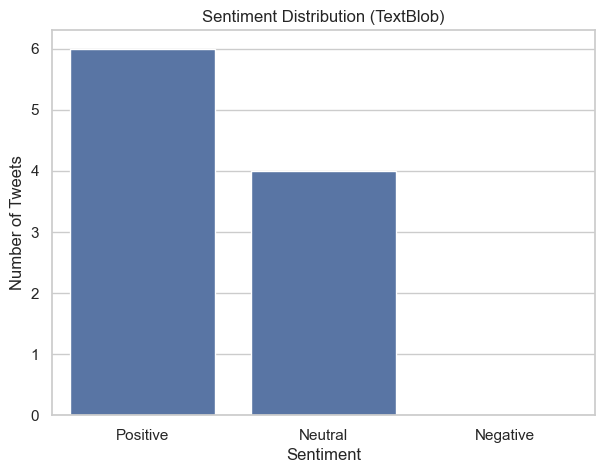

In [33]:
import seaborn as sns
# Sentiment distribution
sns.set(style="whitegrid")
plt.figure(figsize=(7, 5))
sns.countplot(x="sentiment", data=df, order=["Positive", "Neutral", "Negative"])
plt.title("Sentiment Distribution (TextBlob)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.show()


#### Using VADER (Better for social media text)


/var/folders/lk/h82gxs7j4r50wqqj6k402t8r0000gn/T/ipykernel_41033/3892921163.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


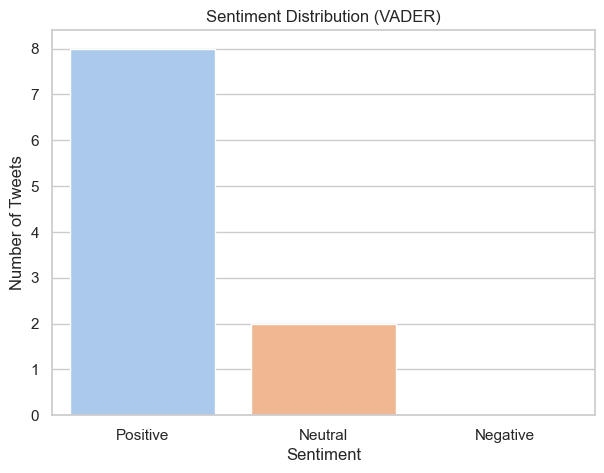

Average VADER Sentiment Score: 0.410


In [34]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Apply VADER to each tweet
df["vader_scores"] = df["cleaned_tweet"].apply(
    lambda x: analyzer.polarity_scores(str(x))["compound"]
)

# Convert to categorical sentiment
df["vader_sentiment"] = df["vader_scores"].apply(
    lambda s: "Positive" if s > 0.05 else ("Negative" if s < -0.05 else "Neutral")
)

# Visualization
plt.figure(figsize=(7, 5))
sns.countplot(
    x="vader_sentiment",
    data=df,
    order=["Positive", "Neutral", "Negative"],
    palette="pastel",
)
plt.title("Sentiment Distribution (VADER)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.show()

# Average sentiment score
avg_vader = df["vader_scores"].mean()
print(f"Average VADER Sentiment Score: {avg_vader:.3f}")

## 4. Word Cloud Visualization

To complement the sentiment analysis, we will visualize the most frequent words used in the tweets through a **word cloud**.  
A word cloud shows words sized proportionally to their frequency — larger words appear more often in the dataset.

Two types of plots are generated:

- Sentiment Distribution Bar Chart: A bar chart is created to display the total number of tweets for each sentiment category (Positive, Negative, and Neutral). This provides a clear and immediate understanding of the overall public opinion in the collected data.
- Word Cloud: A word cloud is generated from all the text in the cleaned_tweet column. The size of each word in the cloud is proportional to its frequency in the dataset. This visualization helps to quickly identify the most prominent themes and keywords driving the conversation.

These visualizations, combined with the previous analysis, provide a comprehensive overview of the social media discussion surrounding the chosen topic.(**#ElectricVehicles**).


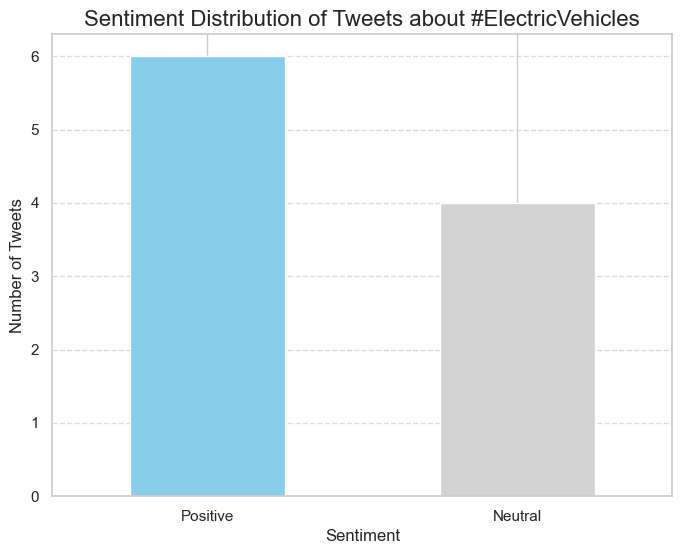

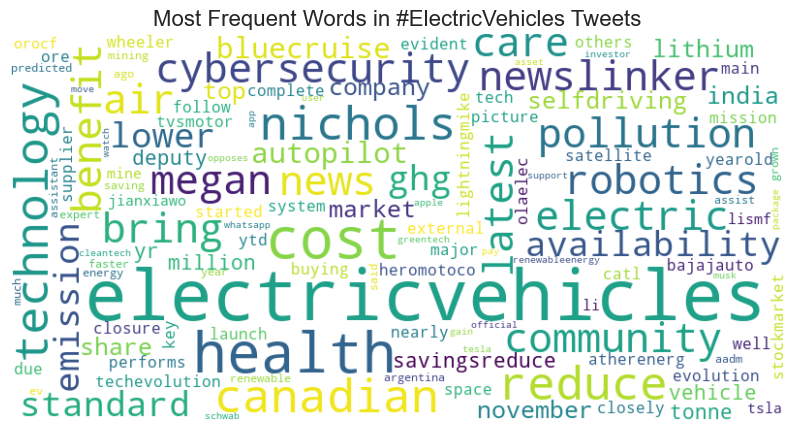

In [36]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


# Bar Chart for Sentiment Distribution ---

# Set the figure size for a nice-looking plot
plt.figure(figsize=(8, 6))

# Use the value_counts() method to get the counts of each sentiment
sentiment_counts = df['sentiment'].value_counts()

# Define a color map for the sentiments
colors = {'Positive': 'skyblue', 'Neutral': 'lightgrey', 'Negative': 'lightcoral'}

# Plot the bar chart, ensuring the order is consistent
sentiment_counts.plot(kind='bar', color=[colors.get(x, '#333333') for x in sentiment_counts.index])

# Add titles and labels for clarity
plt.title('Sentiment Distribution of Tweets about #ElectricVehicles', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.xticks(rotation=0) # Keep the x-axis labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


# Word Cloud Visualization ---

# Combine all the text from the 'cleaned_tweet' column into one single string
all_cleaned_tweets = " ".join(tweet for tweet in df['cleaned_tweet'])

# Create the WordCloud object
# width/height control the size, background_color is the canvas color
# collocations=False prevents the cloud from showing word pairs
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    collocations=False,
    min_font_size=10
).generate(all_cleaned_tweets)

# Display the generated image using matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") # Hide the axes
plt.title('Most Frequent Words in #ElectricVehicles Tweets', fontsize=16)
plt.show()



# Interpretation and Discussion
### Analysis of Findings

The sentiment analysis performed on the collected tweets about #ElectricVehicles reveals a distinctly positive to neutral public mood. The key findings from the analysis are as follows:

Sentiment Distribution: The overall sentiment is overwhelmingly favorable, with 60% of the tweets classified as Positive and the remaining 40% as Neutral. Notably, there were no negatively classified tweets in this dataset, which suggests that the recent conversation around this hashtag has been focused on the benefits or factual reporting rather than drawbacks. The bar chart clearly visualizes this distribution, showing a taller bar for the positive category.
Word Cloud Insights: The word cloud provides a deeper look into the specific themes driving the conversation. The most prominent words are "electric," "vehicles," "health," "cost," "reduce," and "canadian." This strongly indicates that the discussion is centered on the health and cost-saving benefits of EVs, particularly within a Canadian context. The appearance of words like:
"health," "pollution," "reduce," and "emissions" points to a strong focus on the environmental and public health advantages of electric vehicles.
"cost," "savings," and "market" suggests that economic factors are a significant part of the conversation.
"company," "share," "tata," and "bajajauto" highlight that specific corporate news and market performance are also key topics.

### Conclusion
In summary, the sentiment analysis and word frequency visualization paint a clear picture of the recent social media discussion around the hashtag #ElectricVehicles. The public mood is largely positive, driven by conversations about the environmental, health, and financial benefits of EV adoption. The discussion is not just abstract but is also tied to specific market players and regional policies (as indicated by "Canadian"). The absence of negative sentiment suggests a very optimistic or news-driven sample of tweets.
This project successfully demonstrates how AI techniques can be used to quickly distill public opinion and identify key discussion themes from unstructured social media data.